In [1]:
import numpy as np
import sys, os, git, lammps_logfile
import warnings
warnings.filterwarnings("ignore")

In [3]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
path_in_folder = current_path[len(git_path)+1:]
sys.path.append(git_path + "/.dependencies/pyplot-perso")
from plttools import PltTools
path_figures = current_path # git_path + "/figures/"
path_data = git_path + "/.dependencies/lammpstutorials-inputs/"+path_in_folder.split('/')[-2]+"/"

In [4]:
color0_light = np.array([0.5, 0.5, 0.5])
color1_light = np.array([1, 0.682, 0.286])
color2_light = np.array([0.008, 0.294, 0.478])
color3_light = np.array([0.267, 0.647, 0.761])

color0_dark = np.array([0.5, 0.5, 0.5])
color1_dark = np.array([1, 0.8, 0.5])
color2_dark = np.array([0.24, 0.58, 1.0])
color3_dark = np.array([0.4, 0.75, 0.85])

colors_light = {
    "color0": color0_light,
    "color1": color1_light,
    "color2": color2_light,
    "color3": color3_light,
}

colors_dark = {
    "color0": color0_dark,
    "color1": color1_dark,
    "color2": color2_dark,
    "color3": color3_dark,
}

In [5]:
log = lammps_logfile.File(path_data + "pull.log")
timestep = 1 # fs
time_0 = log.get("Step", run_num=0)*timestep/1000 # ps
rgyr_0 = log.get("c_rgyr", run_num=0)
time_1 = log.get("Step", run_num=1)*timestep/1000 # ps
rgyr_1 = log.get("c_rgyr", run_num=1)

In [6]:
f = open(path_data + "pull.dat", "r")
data = []
t = 0
for l in f:
    if len(l.split(" ")) == 4:
        try:
            n = np.int32(l.split(" ")[0])
            if n == 1:
                t += 1
            v = np.float32(l.split(" ")[1])
            b = np.int32(l.split(" ")[2])
            if b==1: # C-C-OE-C # b == 2: # O-C-C-O
                data.append([t, v])
        except:
            pass
f.close()
data = np.array(data)

all_n = np.int32(data[:,0])
before = []
after = []
for n in range(1,t):
    x = data[all_n == n][:,1]
    a, b = np.histogram(x, range=(0, 180), bins=50)
    b = (b[1:]+b[:-1])/2
    if n < 300:
        before.append(a)
    elif n > 340:
        after.append(a)
histogram_before = np.mean(before, axis=0)
histogram_after = np.mean(after, axis=0)

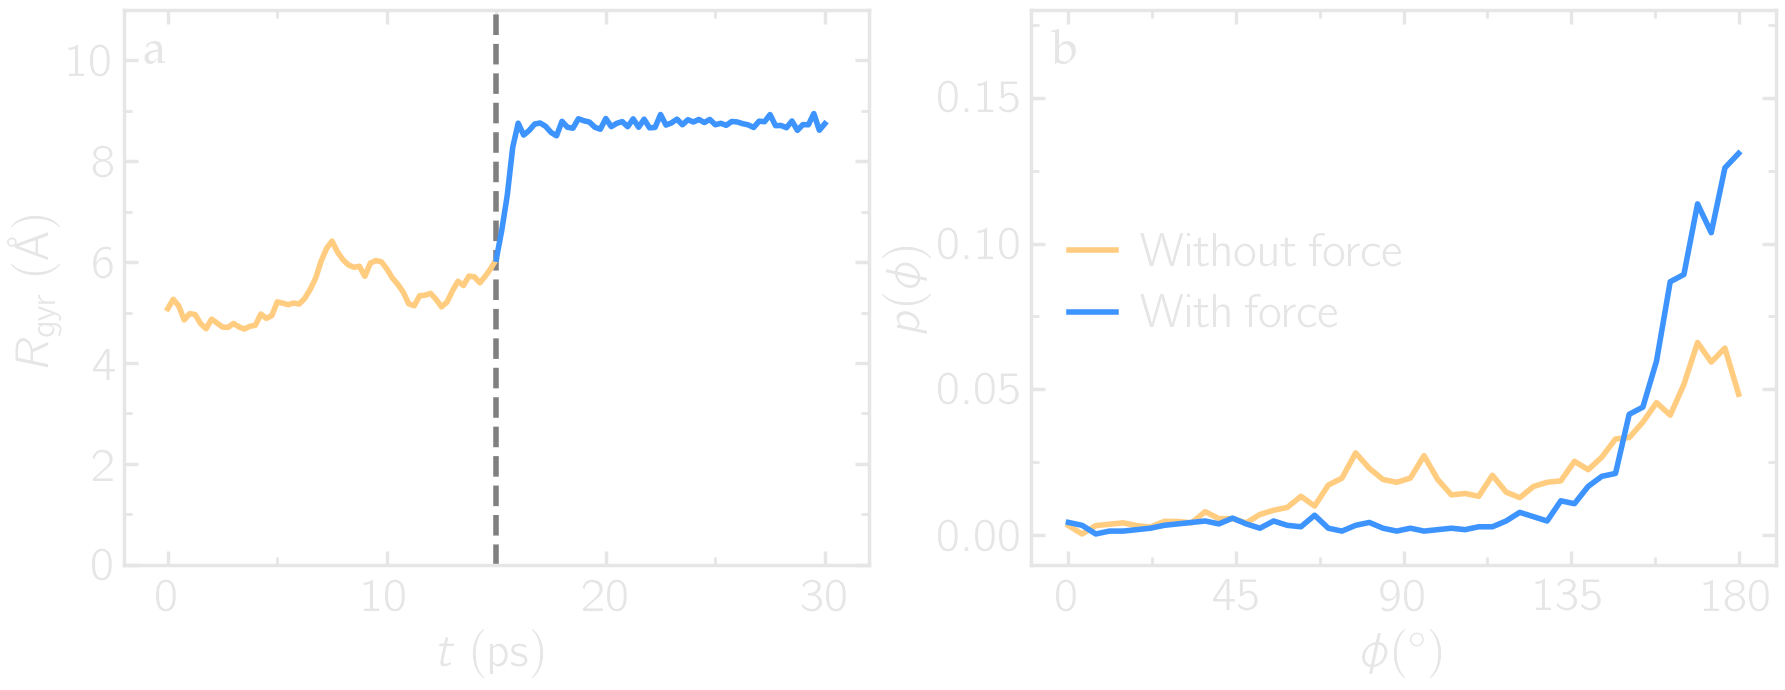

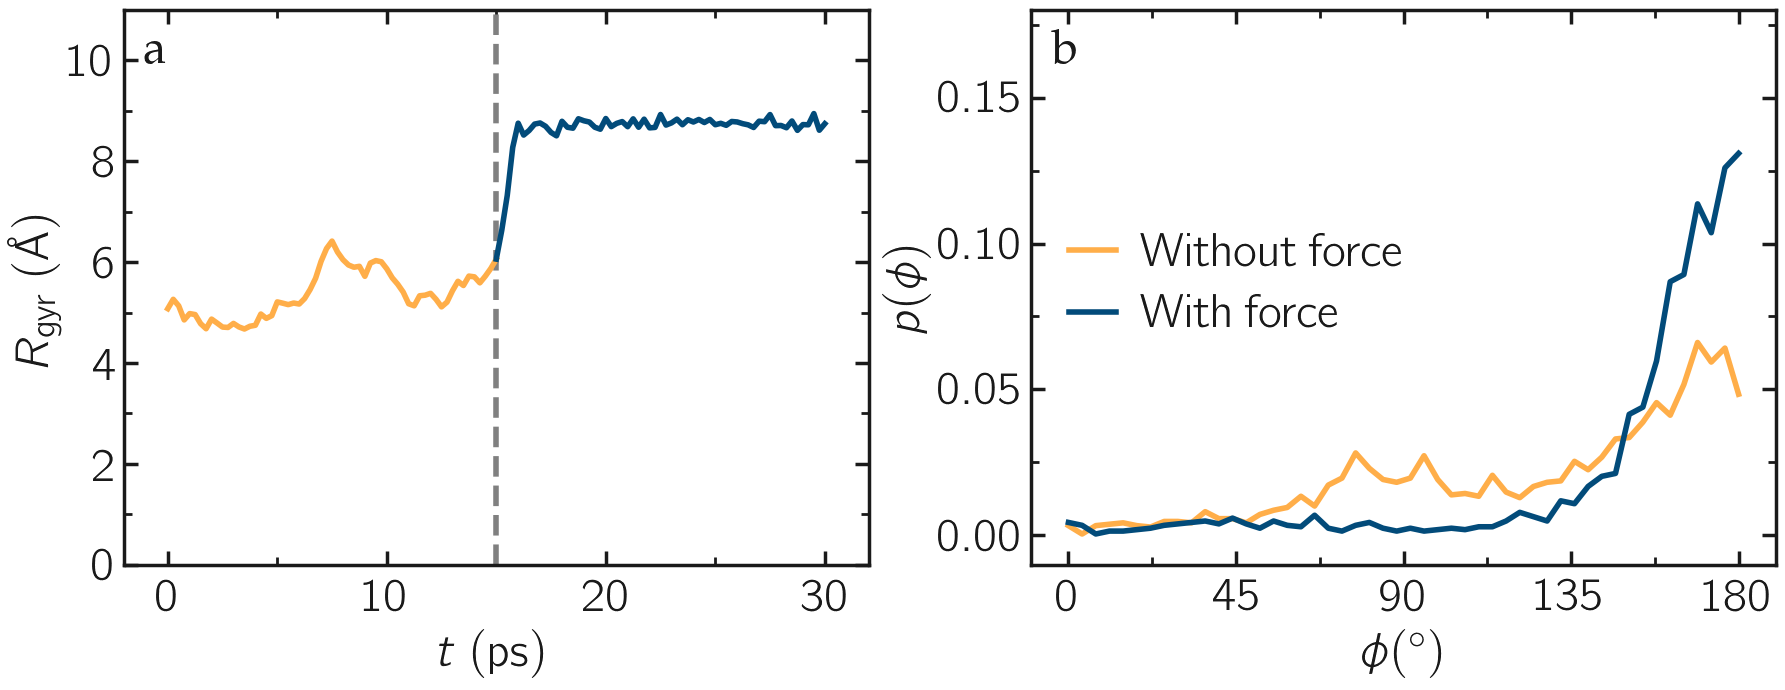

In [8]:
filename = "PEG-distance"


for dark_mode in [True, False]:

    colors = colors_dark if dark_mode else colors_light
    globals().update(colors)

    # Initialise figure
    myplt = PltTools()
    myplt.prepare_figure(fig_size = (18,7), dark_mode = dark_mode,
                        transparency = True, use_serif=True, n_colone=2)
    # Panel a
    myplt.add_panel()
    x = np.linspace(0, 11)
    myplt.add_plot(x = x*0+15, y = x, type = "plot", linewidth_data = 1.5,
                marker = "--", data_color = color0, markersize = 12)
    myplt.add_plot(x = time_0-25, y = rgyr_0, type = "plot", linewidth_data = 3,
                marker = "-", data_color = color1, markersize = 12)
    myplt.add_plot(x = time_1-25, y = rgyr_1, type = "plot", linewidth_data = 3,
                marker = "-", data_color = color2, markersize = 12)
    myplt.complete_panel(xlabel = r'$t ~ \mathrm{(ps)}$',
                        ylabel = r'$R_\mathrm{gyr}~\mathrm{(\AA{})}$',
                        xpad = 10, legend=True, handlelength_legend=1)
    myplt.set_boundaries(x_ticks=np.arange(0, 32, 10), y_ticks=np.arange(0, 11, 2),
                        x_boundaries=(-2, 32), y_boundaries=(0, 11))

    # Panel b
    myplt.add_panel()
    myplt.add_plot(x = np.linspace(0, 180, 50), y = histogram_before/np.sum(histogram_before), type = "plot",
                linewidth_data = 3, marker = "-", data_color = color1, markersize = 12, data_label=r"$\mathrm{Without~force}$")
    myplt.add_plot(x = np.linspace(0, 180, 50), y = histogram_after/np.sum(histogram_after), type = "plot",
                linewidth_data = 3, marker = "-", data_color = color2, markersize = 12, data_label=r"$\mathrm{With~force}$")
    myplt.complete_panel(xlabel = r'$\phi (^\circ)$',
                        ylabel = r'$p (\phi)$',
                        xpad = 10, legend=True, handlelength_legend=1)
    myplt.set_boundaries(x_ticks=np.arange(0, 185, 45), y_ticks=np.arange(0, 0.17, 0.05),
                        x_boundaries=(-10, 190), y_boundaries=(-0.01, 0.18))

    # Print figure
    myplt.add_subplotlabels()
    myplt.save_figure(filename = filename, saving_path = path_figures)